### Methodology

Instance type used c3.8xlarge
OS, amazon linux, but centos 7 should work too



### Setup

#### Kernel Modules

Make sure the relevant crypto modules are loaded into the kernel (if available for your platform).

```bash
$ for m in aesni_intel sha512-ssse3 sha1-ssse3 sha256 sha256-sse; do sudo modprobe $m; done
```

#### Software Deps

```bash
$ sudo yum install -y python-devel python-pip libffi-devel nasm haveged sysstat zlib-devel
$ sudo yum groupinstall -y "Development tools"
$ curl -O http://download.gna.org/cryptodev-linux/cryptodev-linux-1.8.tar.gz
$ tar xf cryptodev-linux-1.8.tar.gz
$ cd cryptodev-linux-1.8/
$ make && sudo make install
$ sudo sh -c 'echo "cryptodev" > /etc/modules-load.d/cryptodev.conf'
$ sudo modprobe cryptodev
$ curl -O ftp://ftp.openssl.org/source/openssl-fips-2.0.12.tar.gz
$ tar xf openssl-fips-2.0.12.tar.gz
$ cd openssl-fips-2.0.12
$ ./config --prefix=/usr --openssldir=/etc/pki/tls zlib threads -DHAVE_CRYPTODEV -DGHASH_ASM -DWHIRLPOOL_ASM -DPURIFY -DOPENSSL_IA32_SSE2 -DOPENSSL_BN_ASM_MONT -DOPENSSL_BN_ASM_MONT5 -DOPENSSL_BN_ASM_GF2m -DSHA1_ASM -DSHA256_ASM -DSHA512_ASM -DMD5_ASM -DAES_ASM -DVPAES_ASM -DBSAES_ASM -DOPENSSL_PIC -DZLIB -DOPENSSL_THREADS -D_REENTRANT -DDSO_DLFCN -DHAVE_DLFCN_H -DKRB5_MIT  -DL_ENDIAN -DTERMIO -fPIC  -m64 -Wall -O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong    -m64 -mtune=native -Wa,--noexecstack  -grecord-gcc-switches && make && sudo make install
$ curl -O https://www.openssl.org/source/openssl-1.0.2g.tar.gz
$ tar xf openssl-1.0.2g.tar.gz
$ cd openssl-1.0.2g
$ ./config --prefix=/usr --with-fipsdir=/usr --with-fipslibdir=/usr/lib64/ --openssldir=/etc/pki/tls fips zlib threads -DHAVE_CRYPTODEV -DGHASH_ASM -DWHIRLPOOL_ASM -DPURIFY -DOPENSSL_IA32_SSE2 -DOPENSSL_BN_ASM_MONT -DOPENSSL_BN_ASM_MONT5 -DOPENSSL_BN_ASM_GF2m -DSHA1_ASM -DSHA256_ASM -DSHA512_ASM -DMD5_ASM -DAES_ASM -DVPAES_ASM -DBSAES_ASM -fPIC -DOPENSSL_PIC -DZLIB -DOPENSSL_THREADS -D_REENTRANT -DDSO_DLFCN -DHAVE_DLFCN_H -DKRB5_MIT -m64 -DL_ENDIAN -DTERMIO -Wall -O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches   -m64 -mtune=native -Wa,--noexecstack && make depend && make && sudo make install
$ sudo pip install -U ndg-httpsclient pyasn1 pyOpenSSL awscli
$ cp $(which aws) ~/aws
$ sudo mkdir /media/ramfs
$ sudo mount -t ramfs -o size=40g ramfs /media/ramfs
```

Add the following to `~/aws` before the `import awscli.clidriver` line.

```python
import botocore.vendored.requests.packages.urllib3.util.ssl_
botocore.vendored.requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS = "AES128-SHA" 
#botocore.vendored.requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS = "aNULL" # If this is working, https should not work if this is enabled
```

### Test Script(s)


```bash
#!/bin/env bash
# This will run 10 concurrent uploads for each of the different scenarios, SSE, SSL, and plaintext.
# It will run each test 5 times.

for i in 1 2 3 4 5; do
    ####################### SSE ###############################
    echo "doing sse $i"
    sar -p 1 > "async_yes_ssl_yes_sse-cpu.${i}.sar.txt" &
    sar_cpu=$!

    sar -p -n DEV 1 > "async_yes_ssl_yes_sse-network.${i}.sar.txt" &
    sar_network=$!

    sleep 1
    
    jobs=""
    for j in 0 1 2 3 4 5 6 7 8 9; do
	~/aws s3 cp /media/ramfs/data/data.30g "s3://psoutham-encryption-test/output/${j}_yes_sse_async_${i}.30g"  --storage-class REDUCED_REDUNDANCY --endpoint-url https://s3-us-west-2.amazonaws.com --sse "aws:kms" --sse-kms-key-id a9de2efa-8278-420c-86ea-272881fcde8d &
	jobs="${jobs} $!"
	usleep 300000 
    done
    echo "waiting for ${jobs}"
    wait ${jobs}
    sleep 1
    kill "${sar_cpu}" "${sar_network}"

    ####################### SSL ###############################

    echo "doing ssl $i"
    sar -p 1 > "async_yes_ssl_no_sse-cpu.${i}.sar.txt" &
    sar_cpu=$!

    sar -p -n DEV 1 > "async_yes_ssl_no_sse-network.${i}.sar.txt" &
    sar_network=$!

    sleep 1
    
    jobs=""
    for j in 0 1 2 3 4 5 6 7 8 9; do
	~/aws s3 cp /media/ramfs/data/data.30g "s3://psoutham-encryption-test/output/${j}_yes_ssl_async_${i}.30g"  --storage-class REDUCED_REDUNDANCY --endpoint-url https://s3-us-west-2.amazonaws.com  &
	jobs="${jobs} $!"
	usleep 300000 
    done
    echo "waiting for ${jobs}"
    wait ${jobs}
    sleep 1
    kill "${sar_cpu}" "${sar_network}"

    ####################### PLAINTEXT ###############################

    echo "doing plaintext $i"
    sar -p 1 > "async_no_ssl_no_sse-cpu.${i}.sar.txt" &
    sar_cpu=$!

    sar -p -n DEV 1 > "async_no_ssl_no_sse-network.${i}.sar.txt" &
    sar_network=$!

    sleep 1
    
    jobs=""
    for j in 0 1 2 3 4 5 6 7 8 9; do
	~/aws s3 cp /media/ramfs/data/data.30g "s3://psoutham-encryption-test/output/${j}_no_ssl_async_${i}.30g"  --storage-class REDUCED_REDUNDANCY --endpoint-url http://s3-us-west-2.amazonaws.com &
	jobs="${jobs} $!"
	usleep 300000 
    done
    echo "waiting for ${jobs}"
    wait ${jobs}
    sleep 1
    kill "${sar_cpu}" "${sar_network}"
done
```

In [58]:
# PREAMBLE
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.style.use('ggplot')
import seaborn as sns
import re
import io
import os.path

In [59]:
### Network I/O

In [60]:
# PROCESS SAR METRICS
FIND_ETH0 = re.compile(".+ ens3 .+")
FIND_CPU = re.compile(".+ all .+")
BW_COLS = ["ts", "rxpck","txpck","rxkB","txkB"]
CPU_COLS = ["cpu"]
SAMPLES = 5

network_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_ETH0.match, open(fname)))), header=None)\
                             .loc[:,[0,3,4,5,6]]
cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_networks = tuple(network_df(os.path.join("reports2", "async_no_ssl_no_sse-network.{}.sar.txt".format(i)))
                              for i in range(1,6))
async_yes_ssl_networks = tuple(network_df(os.path.join("reports2", "async_yes_ssl_no_sse-network.{}.sar.txt".format(i)))
                               for i in range(1,6))
async_yes_sse_networks = tuple(network_df(os.path.join("reports2", "async_yes_ssl_yes_sse-network.{}.sar.txt".format(i)))
                               for i in range(1,6))

async_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in range(1, SAMPLES+1))
async_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(1, SAMPLES+1))
async_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(1, SAMPLES+1))

for df in async_no_ssl_networks + async_yes_sse_networks + async_yes_ssl_networks:
    df.columns = BW_COLS

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_no_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_no_ssl_networks, 1)})
async_no_ssl_network.df_name = "no_ssl_network"
async_yes_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_yes_ssl_networks, 1)})
async_yes_ssl_network.df_name = "yes_ssl_network"
async_yes_sse_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(async_yes_sse_networks, 1)})
async_yes_sse_network.df_name = "yes_sse_network"

async_cpu = (async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu)
async_network = (async_no_ssl_network, async_yes_ssl_network, async_yes_sse_network)

for df in async_cpu + async_network:
    df["sample_mean"] = df[list(map("s{}".format, range(1, SAMPLES+1)))].mean(1)

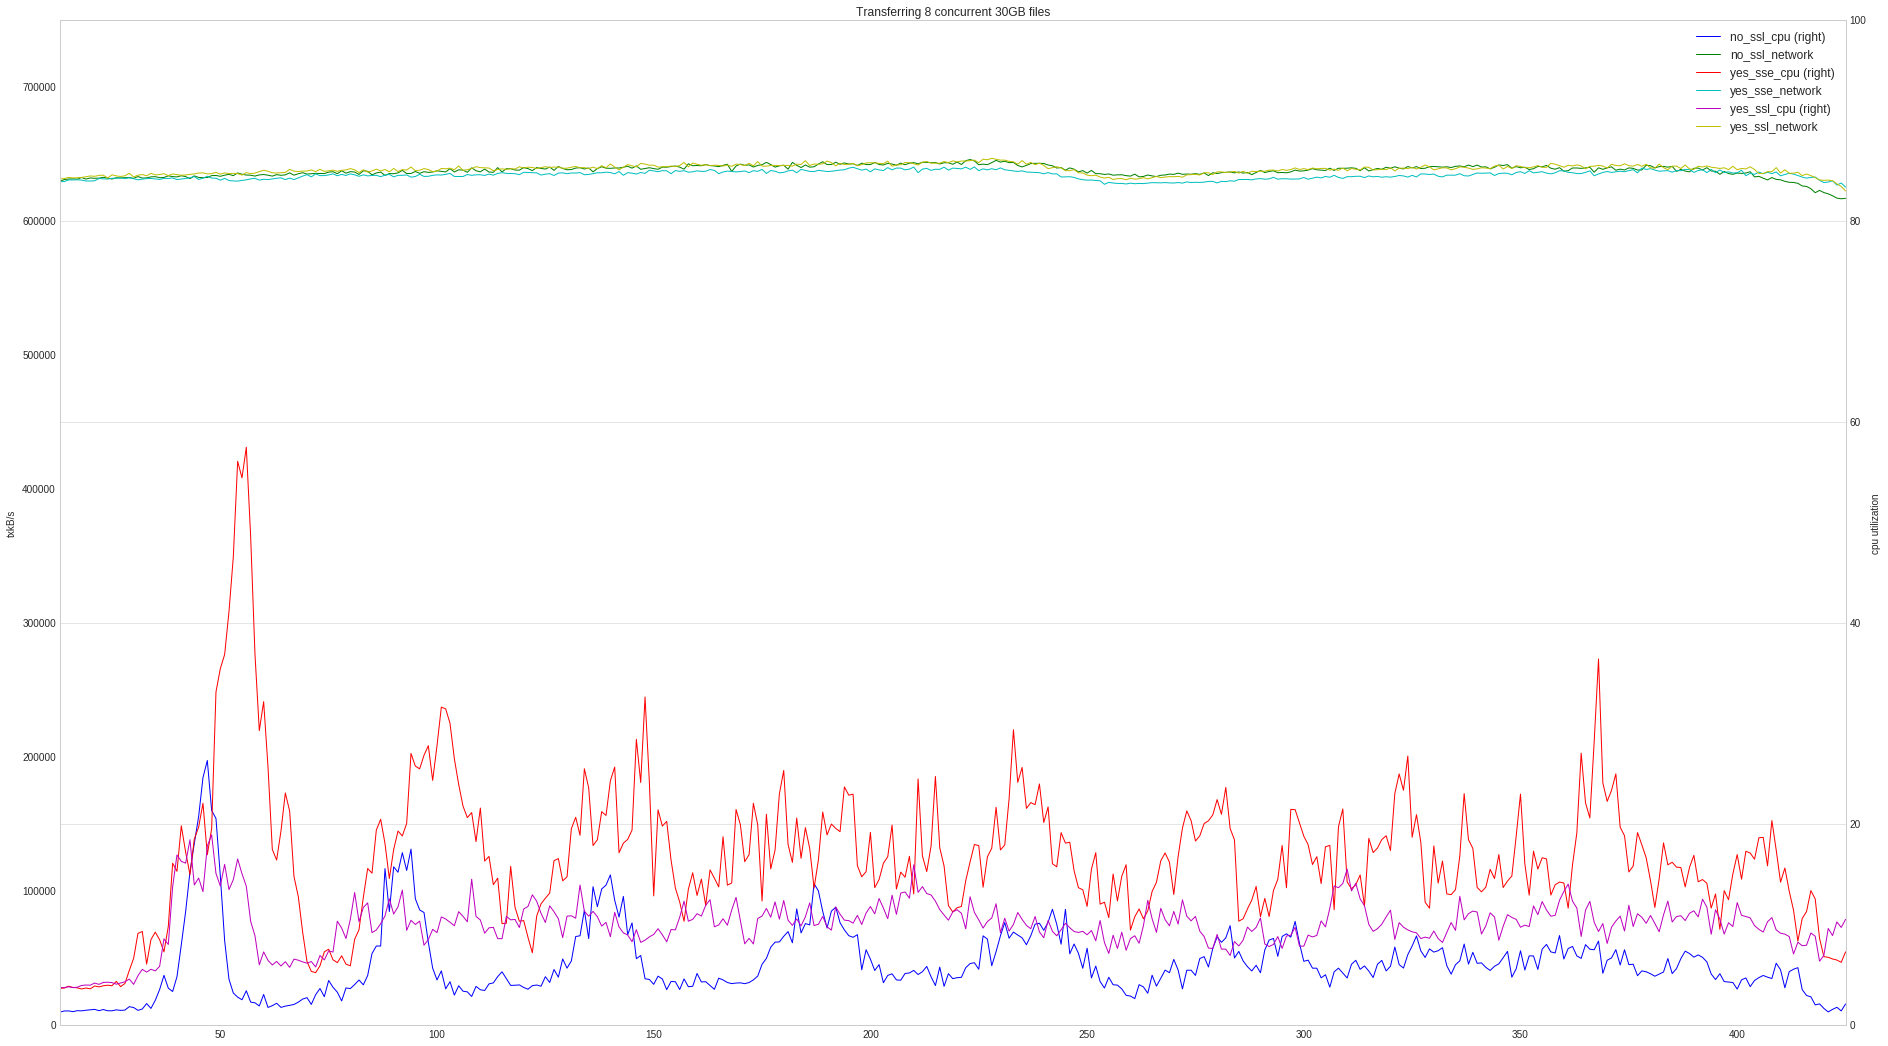

In [61]:
plt.figure()

summary = pd.DataFrame({df.df_name: df.sample_mean for df in async_cpu + async_network}).loc[13:425,]
summary_plt = summary.plot(
    secondary_y=[df.df_name for df in async_cpu], 
    mark_right=True,
    figsize=(16*2, 9*2)
)
summary_plt.set_ylabel("txkB/s")
summary_plt.set_ybound(0,750000)
summary_plt.right_ax.set_ylabel("cpu utilization")
summary_plt.right_ax.set_ybound(0,100)
summary_plt.set_title("Transferring 8 concurrent 30GB files")

In [62]:
summary.mean()

no_ssl_cpu              6.152392
no_ssl_network     637761.608068
yes_sse_cpu            16.798465
yes_sse_network    634548.766576
yes_ssl_cpu             9.976576
yes_ssl_network    638911.628378
dtype: float64

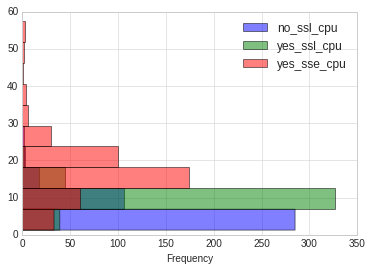

In [63]:
summary[[df.df_name for df in async_cpu]].plot.hist(
    stacked=False, 
    alpha=0.5,
    orientation='horizontal'
)

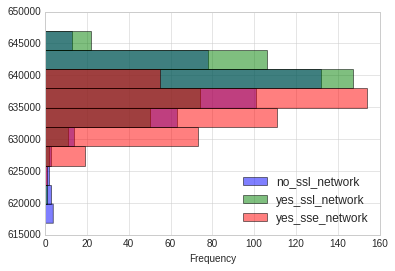

In [64]:
summary[[df.df_name for df in async_network]].plot.hist(
    stacked=False, 
    alpha=0.5,
    orientation='horizontal'
)

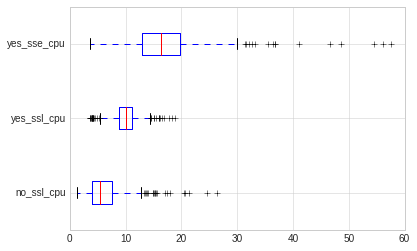

In [65]:
summary[[df.df_name for df in async_cpu]].plot.box(vert=False)

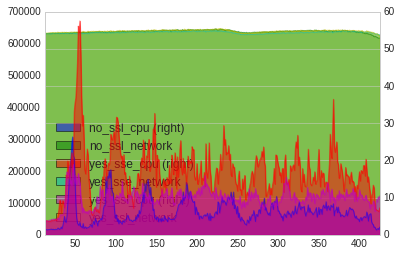

In [66]:
summary.plot.area(
    secondary_y=[df.df_name for df in async_cpu], 
    mark_right=True,
    alpha=.5,
    stacked=False
)

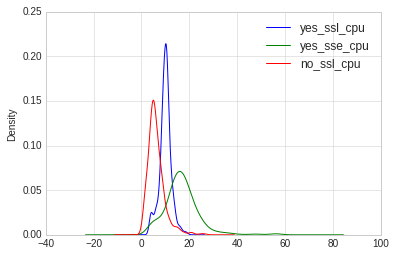

In [67]:
summary[["yes_ssl_cpu", "yes_sse_cpu", "no_ssl_cpu"]].plot.kde()

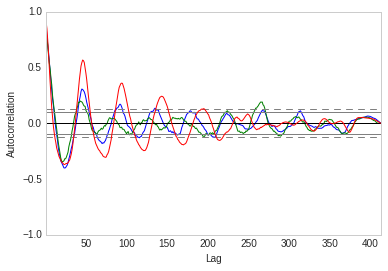

In [68]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(summary.yes_sse_cpu)
autocorrelation_plot(summary.yes_ssl_cpu)
autocorrelation_plot(summary.no_ssl_cpu)

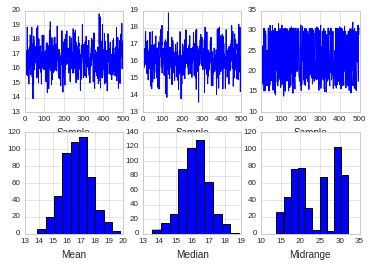

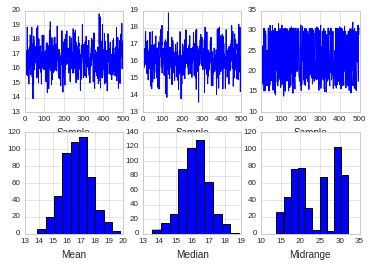

In [69]:
from pandas.tools.plotting import bootstrap_plot
bootstrap_plot(summary.yes_sse_cpu)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e09cb7748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8e09ac3550>], dtype=object)

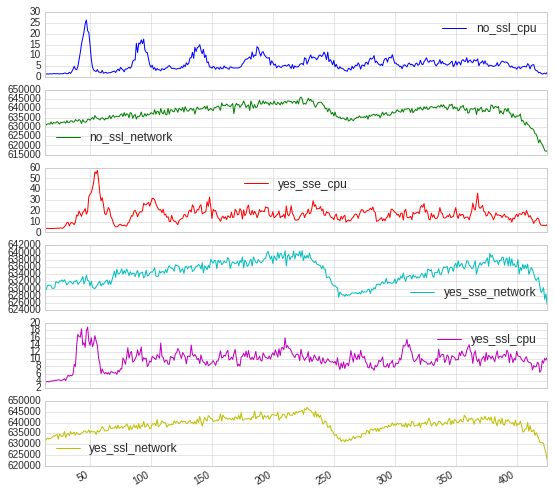

In [70]:
summary.plot(subplots=True, figsize=(9,9))

In [71]:
# PROCESS SAR METRICS
SAMPLES=8

single_no_ssl_networks = tuple(network_df(os.path.join("reports2", "single_no_ssl_no_sse-network.{}.sar.txt".format(i)))
                              for i in range(0, SAMPLES))
single_yes_ssl_networks = tuple(network_df(os.path.join("reports2", "single_yes_ssl_no_sse-network.{}.sar.txt".format(i)))
                               for i in range(0, SAMPLES))
single_yes_sse_networks = tuple(network_df(os.path.join("reports2", "single_yes_ssl_yes_sse-network.{}.sar.txt".format(i)))
                               for i in range(0, SAMPLES))

single_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in range(0, SAMPLES))
single_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(0, SAMPLES))
single_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in range(0, SAMPLES))

for df in single_no_ssl_networks + single_yes_sse_networks + single_yes_ssl_networks:
    df.columns = BW_COLS

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_no_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_no_ssl_networks)})
single_no_ssl_network.df_name = "no_ssl_network"
single_yes_ssl_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_yes_ssl_networks)})
single_yes_ssl_network.df_name = "yes_ssl_network"
single_yes_sse_network = pd.DataFrame({"s{}".format(i): df.txkB for (i,df) in enumerate(single_yes_sse_networks)})
single_yes_sse_network.df_name = "yes_sse_network"

single_cpu = (single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu)
single_network = (single_no_ssl_network, single_yes_ssl_network, single_yes_sse_network)

for df in single_cpu + single_network:
    df["sample_mean"] = df[list(map("s{}".format, range(0, SAMPLES)))].mean(1)

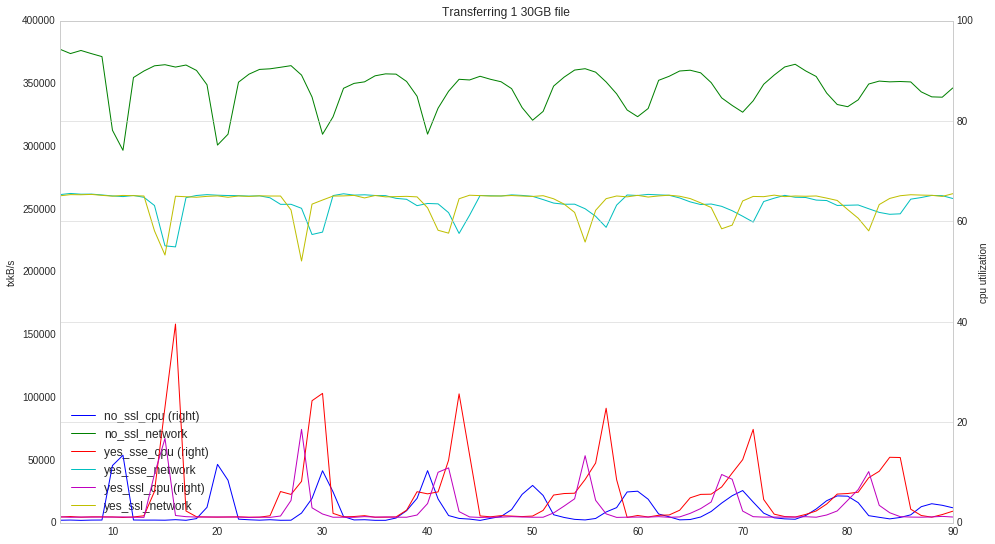

In [72]:
plt.figure()

single_summary = pd.DataFrame({df.df_name: df.sample_mean for df in single_cpu + single_network}).loc[5:90,]
single_summary_plt = single_summary.plot(
    secondary_y=[df.df_name for df in single_cpu], 
    mark_right=True,
    figsize=(16, 9)
)
single_summary_plt.set_ybound(0,400000)
single_summary_plt.set_ylabel("txkB/s")
single_summary_plt.right_ax.set_ylabel("cpu utilization")
single_summary_plt.right_ax.set_ybound(0,100)
single_summary_plt.set_title("Transferring 1 30GB file")

In [73]:
single_summary.mean()

no_ssl_cpu              2.754448
no_ssl_network     347551.168183
yes_sse_cpu             5.639157
yes_sse_network    254631.789578
yes_ssl_cpu             2.758503
yes_ssl_network    255344.722544
dtype: float64

### Disk I/O

In [74]:
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): #"gpt-e", 
    with open(os.path.join("reports", "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])

In [75]:
bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]

for l in ("put_block", "get_block", "put_block_cpu", "get_block_cpu"):
    bonnie[l] = bonnie[l].apply(int)
    
for l in ("put_block_latency", "get_block_latency"):
    bonnie[l] = bonnie[l].apply(lambda x: int(x[:-2]) if x[-2:] == "us" else int(x[:-2])*1000)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e0acab128>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8e09839710>], dtype=object)

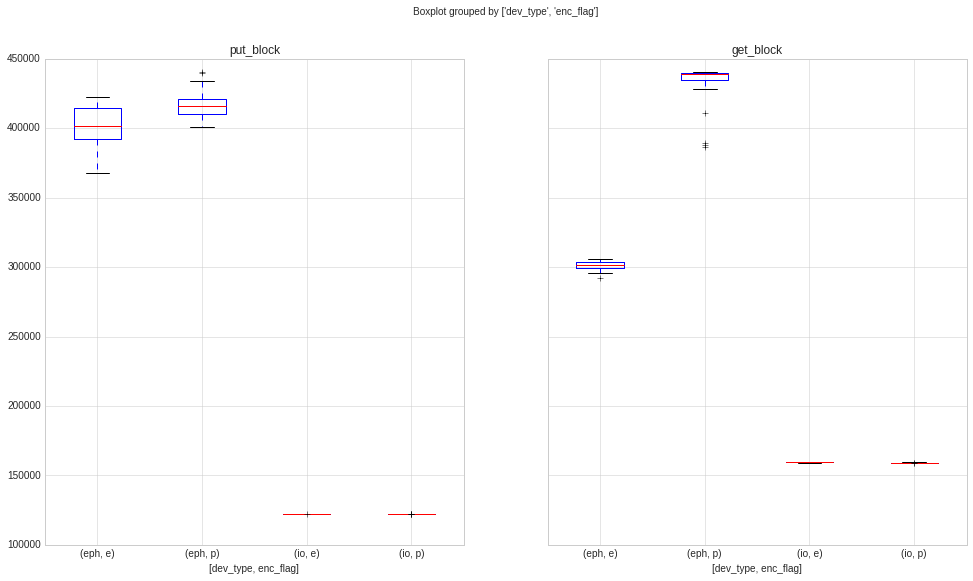

In [76]:
bonnie.boxplot(by=["dev_type", "enc_flag"], 
           column=["put_block", "get_block"], 
           figsize=(16,9))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e096e70b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8e096af198>], dtype=object)

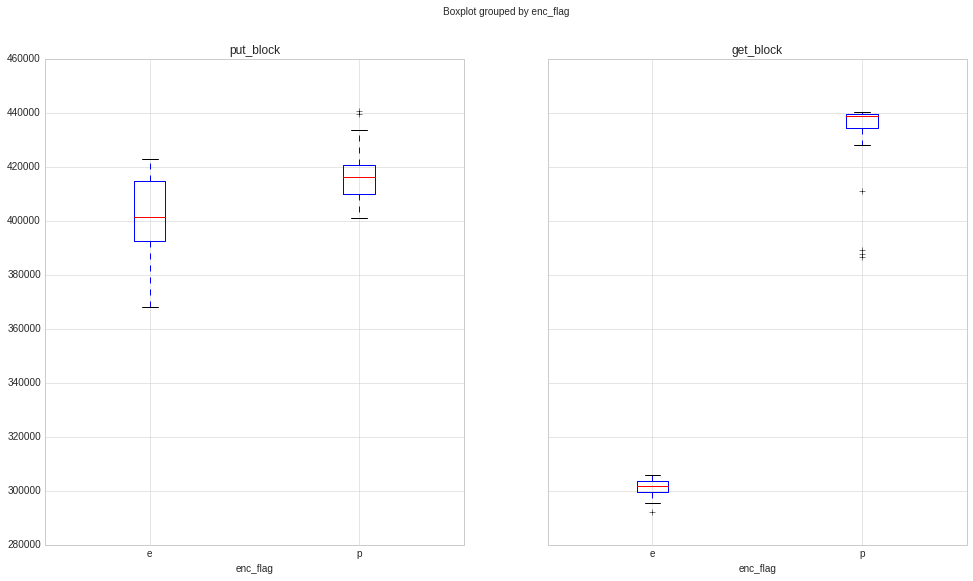

In [77]:
bonnie[bonnie.dev_type == "eph"].boxplot(by="enc_flag", 
           column=["put_block", "get_block"],           
           figsize=(16,9))

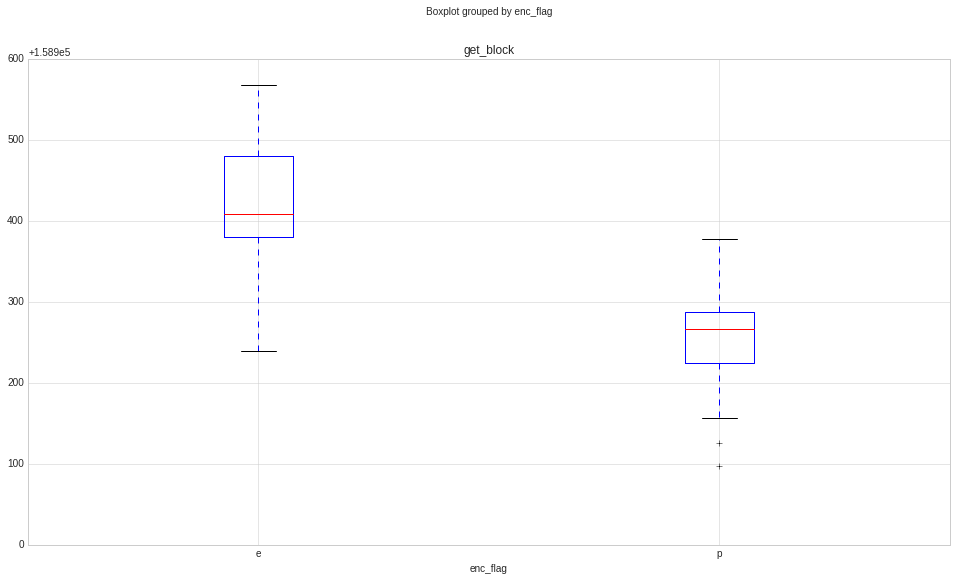

In [78]:
bonnie[bonnie.dev_type == "io"].boxplot(by="enc_flag", 
           column="get_block",           
           figsize=(16,9))

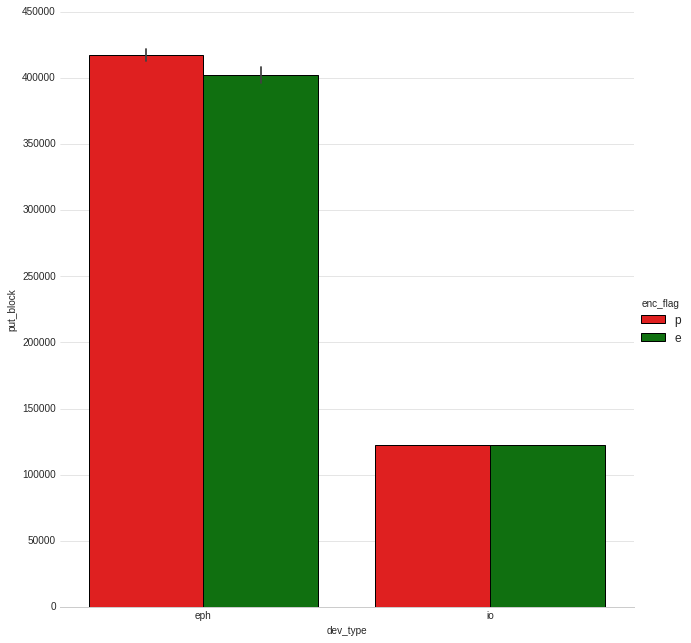

In [79]:
g = sns.factorplot(x="dev_type", y="put_block", hue="enc_flag", data=bonnie,
                  kind="bar", size=9,palette=['r','g'])
g.despine(left=True)

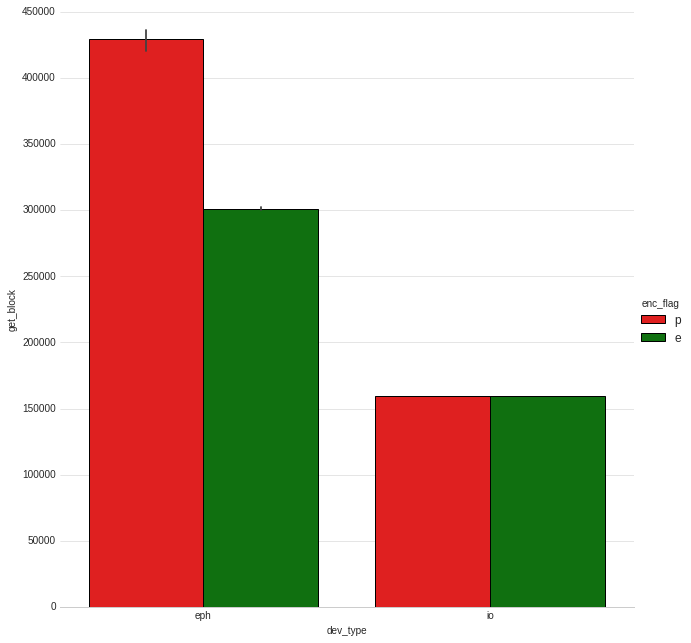

In [80]:
g = sns.factorplot(x="dev_type", y="get_block", hue="enc_flag", data=bonnie,
                  kind="bar", size=9,palette=['r','g'])
g.despine(left=True)

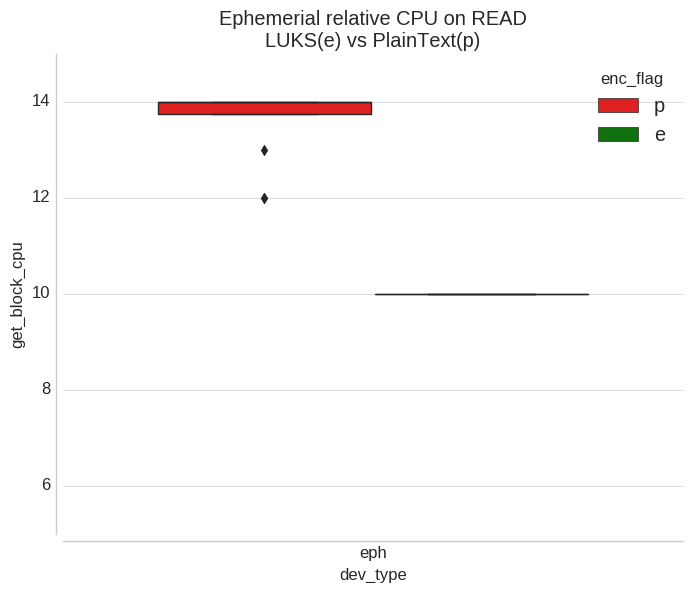

In [81]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="get_block_cpu", hue="enc_flag", data=bonnie[bonnie.dev_type == "eph"],palette=['r','g'],width=.7)
g.set_title("Ephemerial relative CPU on READ\nLUKS(e) vs PlainText(p)")
g.set_ybound(5,15)
sns.despine(offset=5)

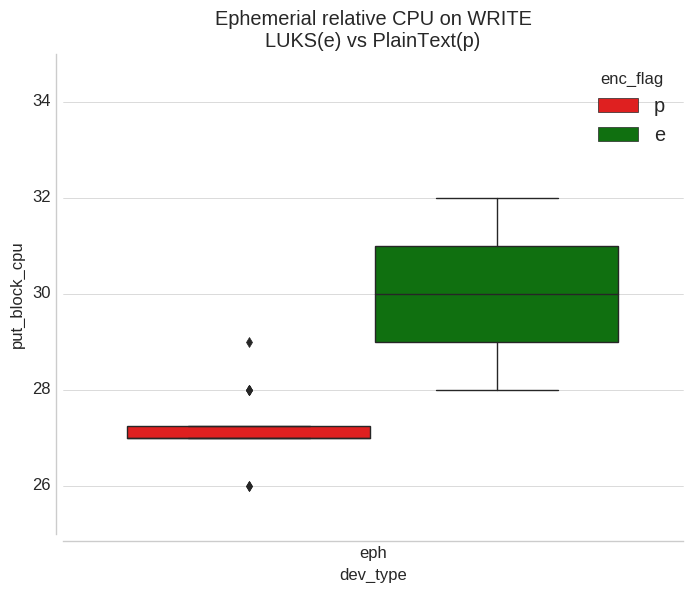

In [82]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="put_block_cpu", hue="enc_flag", data=bonnie[bonnie.dev_type == "eph"],palette=['r','g'], width=.8)
g.set_title("Ephemerial relative CPU on WRITE\nLUKS(e) vs PlainText(p)")
g.set_ybound(25,35)
sns.despine(offset=5)

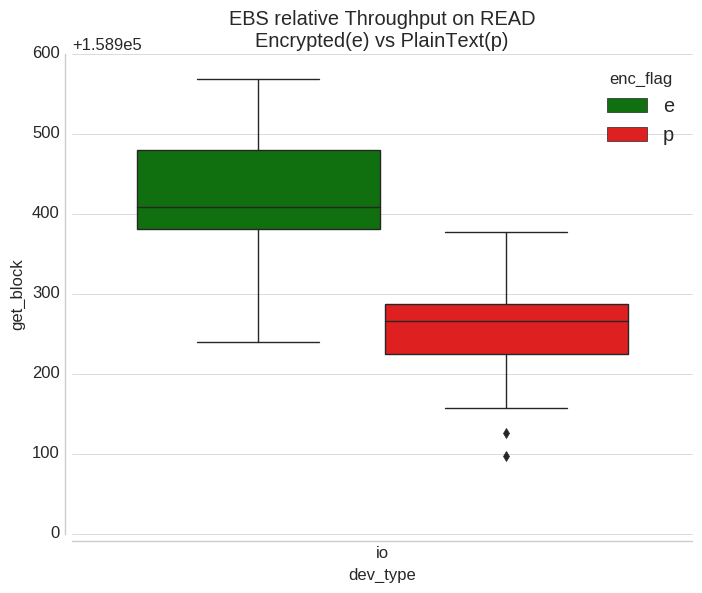

In [83]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="get_block", hue="enc_flag", data=bonnie[bonnie.dev_type == "io"],palette=['g','r'], width=.8)
g.set_title("EBS relative Throughput on READ\nEncrypted(e) vs PlainText(p)")
sns.despine(offset=5)

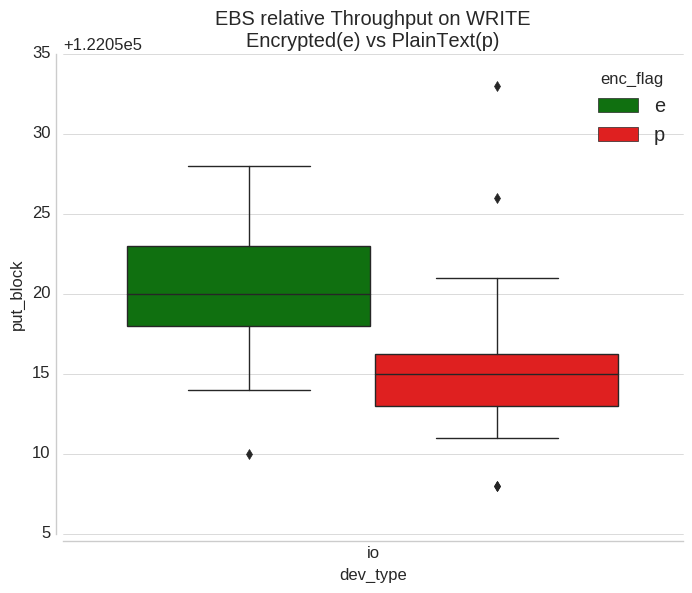

In [84]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="put_block", hue="enc_flag", data=bonnie[bonnie.dev_type == "io"],palette=['g','r'], width=.8)
g.set_title("EBS relative Throughput on WRITE\nEncrypted(e) vs PlainText(p)")
sns.despine(offset=5)

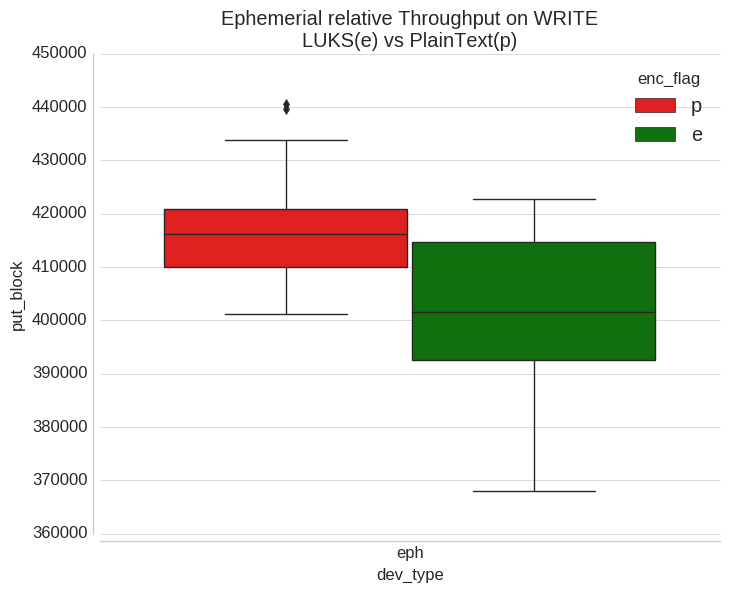

In [85]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="put_block", hue="enc_flag", data=bonnie[bonnie.dev_type == "eph"],palette=['r','g'], width=.8)
g.set_title("Ephemerial relative Throughput on WRITE\nLUKS(e) vs PlainText(p)")
sns.despine(offset=5)

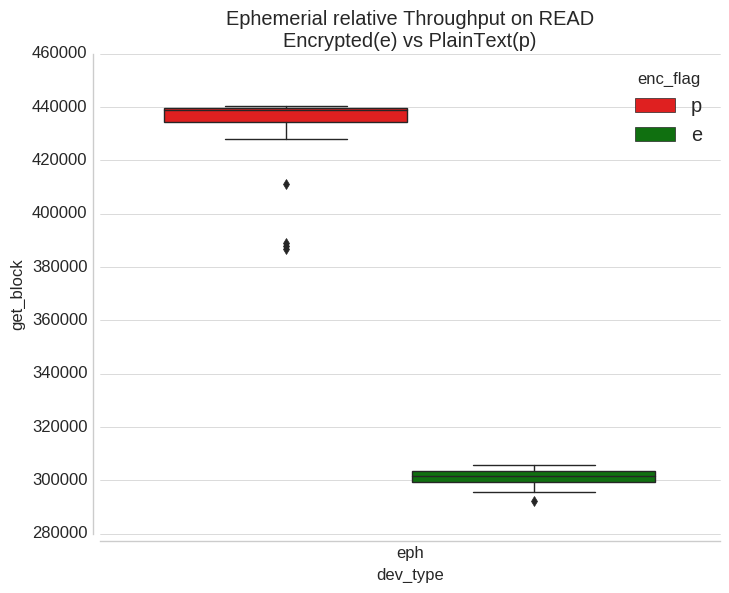

In [86]:
sns.reset_defaults()
sns.set_style("whitegrid")
g = sns.boxplot(x="dev_type", y="get_block", hue="enc_flag", data=bonnie[bonnie.dev_type == "eph"],palette=['r','g'], width=.8)
g.set_title("Ephemerial relative Throughput on READ\nEncrypted(e) vs PlainText(p)")
sns.despine(offset=5)

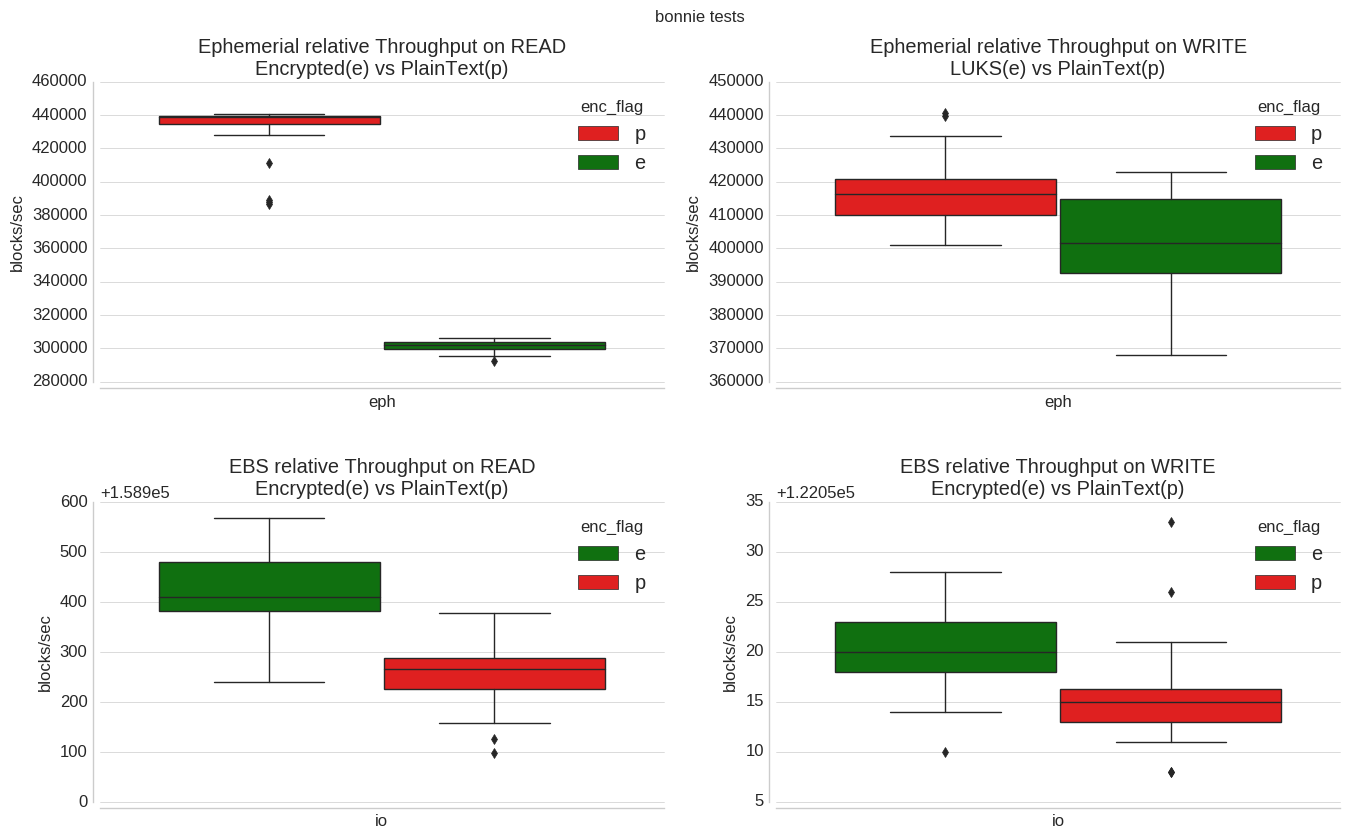

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
_ = fig.suptitle("bonnie tests")
g_er = sns.boxplot(x="dev_type", y="get_block",
                hue="enc_flag", 
                data=bonnie[bonnie.dev_type == "eph"],
                palette=['r','g'],
                width=.8,
                ax=axes[0, 0])
g_er.set_title("Ephemerial relative Throughput on READ\nEncrypted(e) vs PlainText(p)")
g_er.set_xlabel("")
g_er.set_ylabel("blocks/sec")
g_ew = sns.boxplot(x="dev_type", y="put_block",
                hue="enc_flag",
                data=bonnie[bonnie.dev_type == "eph"],
                palette=['r','g'],
                width=.8,
                ax=axes[0, 1])
g_ew.set_title("Ephemerial relative Throughput on WRITE\nLUKS(e) vs PlainText(p)")
g_ew.set_xlabel("")
g_ew.set_ylabel("blocks/sec")

g_ir = sns.boxplot(x="dev_type", y="get_block",
                hue="enc_flag",
                data=bonnie[bonnie.dev_type == "io"],
                palette=['g','r'],
                width=.8,
                ax=axes[1, 0]
               )
g_ir.set_title("EBS relative Throughput on READ\nEncrypted(e) vs PlainText(p)")
g_ir.set_xlabel("")
g_ir.set_ylabel("blocks/sec")

g_iw = sns.boxplot(x="dev_type", y="put_block",
                hue="enc_flag",
                data=bonnie[bonnie.dev_type == "io"],
                palette=['g','r'],
                width=.8,
                ax=axes[1, 1]
               )
g_iw.set_title("EBS relative Throughput on WRITE\nEncrypted(e) vs PlainText(p)")
g_iw.set_xlabel("")
g_iw.set_ylabel("blocks/sec")

sns.despine(offset=5)
fig.subplots_adjust(hspace=0.4)